# Neural citation network for local citation recommendation

In [1]:
import torch
from torchtext.data import BucketIterator
from ncn.evaluation import Evaluator
from ncn.data import get_datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [2]:
path_to_weights = "/home/timo/Downloads/ncn/model/NCN_9_4_4_128_filters.pt"
path_to_data = "/home/timo/DataSets/KD_arxiv_CS/arxiv_data.csv"

In [3]:
data = data = get_datasets(path_to_data, 20000, 20000, 20000)

INFO:ncn.data:Getting fields...
INFO:ncn.data:Loading dataset...
INFO:ncn.data:Building vocab...


In [4]:
def display_dict(d):
    """Display a dict nice and pretty."""
    for key, value in d.items():
        print(f"Citation rank {key}|\t {value}")

In [5]:
def display_attention(title, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap="plasma")
   
    ax.tick_params(labelsize=15)
    xlabels = ["Context TDNN 1 (f=4)", "Context TDNN 2 (f=4)", "Context TDNN 3 (f=5)", 
               "Context TDNN 3 (f=6)", "Context TDNN 3 (f=7)",
               "Citing TDNN 1 (f=1)", "Citing TDNN 2 (f=2)",
               "Cited TDNN 1 (f=1)", "Cited TDNN 2 (f=2)"
              ]
    ax.set_xticklabels([''] + xlabels, 
                       rotation=90)
    # have tokenized title here
    ax.set_yticklabels([''] + title)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(cax)
    plt.tight_layout()
    fig.savefig("Attention_weights.jpg", DPI=400)

# ![stats_icon](assets/Stats_icon.png) Data: Basic statistics
* __502353 context - citation pairs__ with full information.  
* Split of __train = 0.8, valid = 0.1, test = 0.1__.   
* Vocab sizes: __context = title = shared authors = 30k__.  

![Context and title length distributions](assets/title_context_distribution.jpg)

* Max __context length__: __50__.
* Max __title length__: __18__.

# ![field_icon](assets/Field_icon.png) Data preprocessing with torchtext Fields 
![Field](assets/Field_viz.JPG)

In [6]:
context = "Neural networks are really cool, especially if they are convolutional."
authors = "Chuck Norris, Bruce Lee"

## Tokenization and Lemmatization

In [7]:
tokenized = data.cntxt.tokenize(context)

In [8]:
tokenized

['Neural',
 'network',
 'be',
 'really',
 'cool',
 'especially',
 'if',
 'they',
 'be',
 'convolutional']

## Numericalization

In [9]:
data.cntxt.numericalize([tokenized])

tensor([[   0,    3,    0,    0, 4628,  773,    0,    0,    0,  411]])

## Batch processing

In [10]:
examples = [example.context for example in data.train.examples[:30]]

In [11]:
tensorized = data.cntxt.numericalize(data.cntxt.pad(examples))

In [12]:
print(f"Batch data type: {tensorized.type()}")
print(f"Batch shape: {tensorized.shape}")
print(tensorized[:3, :])

Batch data type: torch.LongTensor
Batch shape: torch.Size([30, 52])
tensor([[  845,     9,    88,  3533,    45,    34,    56,   620,    49,   279,
          1050,     5,   649,  1617,   541,   352,   100,   150,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [  392,   170,    46, 18853,   725,  2502,   201,     0,   578,    44,
             0, 15008,   181,    87,   218,  1135,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1],
        [ 1749,  1601,   823,  2003,   103,    92,   648,  2003,   388,   117,
           151,

# ![bucketing_icon](assets/Bucketing_icon.png) Bucketing: What is it and why do we need it?
![Bucketing](assets/Bucketing_viz.JPG)

In [13]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((data.train, data.valid, data.test), 
                                                                          batch_size = 32,
                                                                          sort_within_batch = True,
                                                                          sort_key = lambda x : len(x.title_cited))

In [14]:
batch = next(iter(train_iterator))

## Bucketed batch
* Sequences in a batch have similar length.
* Drastically reduces computation time.  

In [15]:
batch.title_cited.permute(1,0)[:5]

tensor([[    2,  1079,   152,     9,    21,   204,    14,    67,     3],
        [    2,   476,   179,   252,   208,   175,   603,   203,     3],
        [    2,    47,   447,   600,    16,    23,   417,    71,     3],
        [    2,   108,   684,    81, 16373,   246,    84,   114,     3],
        [    2,    57,   176,     4,   116,  2816,  1023,  1172,     3]])

# ![demo_icon](assets/Demo_icon.png) Demo

In [16]:
evaluator = Evaluator([4,4,5,6,7], [1,2], 128, 128, 2,  path_to_weights, data, evaluate=False, show_attention=True)

INFO:ncn.evaluation:INITIALIZING NEURAL CITATION NETWORK WITH AUTHORS = True
Running on: cpu
Number of model parameters: 16,728,996
Encoders: # Filters = 128, Context filter length = [4, 4, 5, 6, 7],  Context filter length = [1, 2]
Embeddings: Dimension = 128, Pad index = 1, Context vocab = 20002, Author vocab = 20002, Title vocab = 20004
Decoder: # GRU cells = 2, Hidden size = 128
Parameters: Dropout = 0.2, Show attention = True
-------------------------------------------------
INFO:ncn.evaluation:Creating corpus in eval=False mode.
INFO:ncn.evaluation:Number of samples in BM25 corpus: 1205646


## Generating Recommendations
* Use BM-25 to preselect the 1028 most similar titles.  
* Rerank those with the neural citation network.  

In [17]:
context = "Neural networks are really cool, especially if they are convolutional."
authors = "Chuck Norris, Bruce Lee"

In [18]:
recomms, a = evaluator.recommend(context, authors, 10)

In [19]:
display_dict(recomms)

Citation rank 0|	 Very deep convolutional networks for   large-scale image recognition
Citation rank 1|	 Imagenet classification with   deep convolutional neural networks
Citation rank 2|	 Fully convolutional networks for   semantic segmentation
Citation rank 3|	 Deep convolutional framelets: A general deep learning   for inverse problems
Citation rank 4|	 Convolutional neural networks for sentence classification
Citation rank 5|	 Caffe: Convolutional architecture for fast   feature embedding
Citation rank 6|	 ImageNetclassification with   deep convolutional neural networks
Citation rank 7|	 Visualizing and understanding convolutional   networks
Citation rank 8|	 U-net: Convolutional networks for   biomedical image segmentation
Citation rank 9|	 Return of the devil   in the details: Delving deep into convolutional nets


# ![attention_icon](assets/Attention_icon.png) But what about attention?

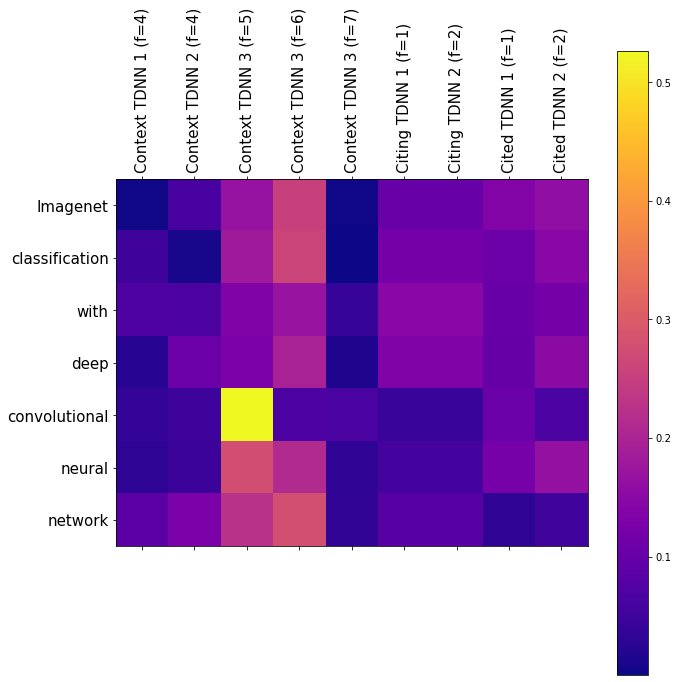

In [20]:
rec = 1
seq = data.cntxt.tokenize(recomms[rec])
display_attention(seq, a[1:len(seq)+1, rec, :])

# ![result_icon](assets/Result_icon.png) Results   

![Recall_at_x](assets/recall.jpg)

For reference: Recall for original paper between 0.2 and 0.3. 

# ![docs_icon](assets/Docs_icon.png) Documentation
![Docs](assets/Documentation.png)